# ДЗ 1, часть 3. ЕМ-алгоритм

Имя, Фамилия: *напишите здесь*

группа: *напишите здесь группу, где вы числитесь*

**Оценка(для проверяющего):** 0 из 10

**Дедлайн:** 5 ноября 23:59 (решение нужно сдать в энитаск)

In [1]:
#all imports here please
import pickle as pkl
import tqdm
import numpy as np
import scipy.stats as spstats
import matplotlib.pyplot as plt
%matplotlib inline
#... add your own if necessary

## Задача 1. Поломки (5 баллов)

В офисе одного небольшого СобериБанка происходят поломки серверной. Служба обслуживания в таких случаях посылает специалиста решить проблему.  Для этого необходимо произвести обслуживание вычислительного узла А и вычислительного узла B. Каждый специалист имеет какую-то свою инструкцию, методологию, а также свой опыт, который определяет то, как именно он занимается ремонтном, и то, сколько времени у него занимают ремонтные работы.

В офисе точно могут сказать, сколько суммарно времени занял ремонт каждого из узлов(в минутах), обозначим их за переменные $X_A,~X_B$, но очень сложно понять, какие конкретно рабочие занимались ремонтом в каждом случае.

Коллеги вас, как экперта в статистике, просят оценить, сколько рабочих занято в ремонте вашей серверной. Немного посидев в браузере, вы узнаёте, что, оказывается, времена обслуживания техники можно моделировать с помощью знакомого [логнормального распределения](https://en.wikipedia.org/wiki/Log-normal_distribution). 

Используя ЕМ-алгоритм, модель смеси распределений, а также приложенный датасет, определите сколько рабочих могло участвовать в ремонте серверной за время наблюдений. Можете ли вы определить, какой рабочий участвовал в каждом ремонте?

Действуем по инструкции.

### Посмотрим на датасет

Откройте приложенный датасет и нарисуйте диаграмму разброса (scatterplot) в осях $X_A,~X_B$, чтобы посмотреть, что в целом дано. Возможно, удобнее перейти в логарифмические оси.

In [2]:
with open("./maintenance.pkl","rb") as f:
    dd = pkl.load(f)

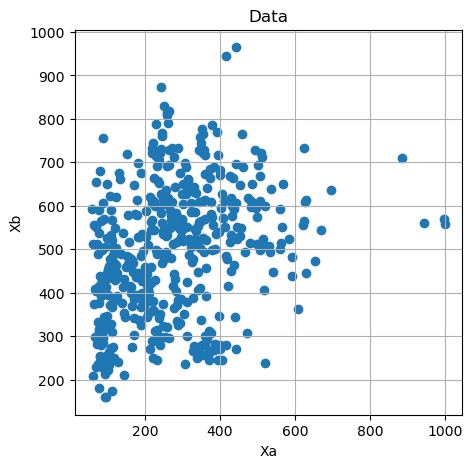

In [3]:
f,ax = plt.subplots(figsize=(5,5))

ax.grid()
ax.set_title("Data")
X_A = dd['times(min)'][:, 0]
X_B = dd['times(min)'][:, 1]
plt.scatter(X_A, X_B)
ax.set_xlabel("Xa")
ax.set_ylabel("Xb")
plt.show()

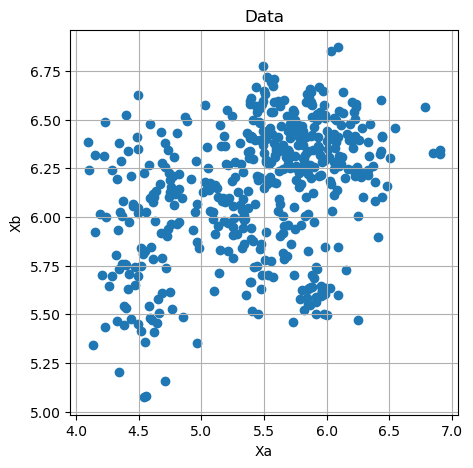

In [4]:
f,ax = plt.subplots(figsize=(5,5))
ax.grid()
ax.set_title("Data")
X_A = np.log(dd['times(min)'].T[0])
X_B = np.log(dd['times(min)'].T[1])
plt.scatter(X_A, X_B)
ax.set_xlabel("Xa")
ax.set_ylabel("Xb")
plt.show()

### Модель

Опишите модель смеси, которая вам пригодится для решения задачи. Число компонент будем определять экспериментально, а остальное надо оценивать. Предполагается, что вектор $[\ln X_A, \ln X_B]$ у каждого рабочего имеет нормальное распределение. Логарифмы $\ln X_A$ и $\ln X_B$ могут быть коррелированы, но пары  $(X^i_A,X^i_B)$ независимы в совокупности.

* Что по смыслу задачи является скрытыми переменными $Y_i$ (номерами компонент)?
* Какое вы можете предложить распределение для пары $(X^i_A, X^i_B)$? Будьте здесь внимательны!
* Какие параметры $\theta$ есть в вероятностной модели?

* Скрытая переменная - рабочий.
* Логнормальное распределение
* $\mu_k$ - $(mean X^i_A, mean X^i_B)$ - среднее время рабочего
* $\pi_{k}$ - вероятнсоть, что принадлежит k-ому рабочему.
* $\Sigma_k = \begin{pmatrix} \sigma^2_{A,k} & cov(\sigma_{A,k} \sigma_{B,k}) \\ cov(\sigma_{A,k} \sigma_{B,k}) & \sigma^2_{B,k} \end{pmatrix}$ — матрица ковариаций, где $\rho_k$ — коэффициент корреляции между $\ln X_A$ и $\ln X_B$.



### Матчасть

Построим математическую основу решения задачи. Выведите и запишите формулы для ЕМ-алгоритма: Е-шаг (вычисление необходимых весов наблюдений) и М-шаг (обновление параметров).

### E-шаг

$$
\gamma_{Y_i}(k) = P(Y_i = k | X^i) 
= \frac{P(X^i, Y_i = k)}{P(X^i)}
= \frac{P(X^i| Y_i = k) P(Y_i = k)}{P(X^i)}
$$
- $
P(X^i| Y_i = k) = \frac{1}{\sqrt{2 \pi|\boldsymbol{\Sigma}_k|}} \exp\left(-\frac{1}{2} (\begin{pmatrix} \ln X^i_A \\ \ln X^i_B \end{pmatrix} - \mu_k)^T \Sigma_k^{-1} (\begin{pmatrix} \ln X^i_A \\ \ln X^i_B \end{pmatrix} - \mu_k)\right)
$
- $P(Y_i = k) = \pi_k$
- $P(X^i)= \sum_{j=1}^{K} P(X^i| Y_i = j) \pi_j$

Тогда:

$$
\gamma_{Y_i}(k) = \frac{P(X^i| Y_i = k) \pi_k}{\sum_{j=1}^{K} P(X^i| Y_i = j) \pi_j}
$$

### M-шаг

$$Q(\theta_t, \theta) = \sum \limits_{i=1}^n  \sum \limits_{k=1}^K \gamma_{Y_i}(k) \left( \ln \pi_k + \ln p_{\theta}(X_i \vert Y_i=k)\right)
$$
$
L= \sum \limits_{i=1}^n  \sum \limits_{k=1}^K \gamma_{Y_i}(k) \left( \ln \pi_k + \ln \frac{1}{\sqrt{2 \pi
|\boldsymbol{\Sigma}_k|}} \exp\left(-\frac{1}{2} (\begin{pmatrix} \ln X^i_A \\ \ln X^i_B \end{pmatrix} - \mu_k)^T \Sigma_k^{-1} (\begin{pmatrix} \ln X^i_A \\ \ln X^i_B \end{pmatrix} - \mu_k)\right)\right) + \lambda(\sum \limits_{k=1}^K \pi_k - 1)
$
$
= \sum \limits_{i=1}^n  \sum \limits_{k=1}^K \gamma_{Y_i}(k) \left( \ln \pi_k + \ln \frac{1}{\sqrt{2 \pi |\boldsymbol{\Sigma}_k|}} - \frac{1}{2} \left(\begin{pmatrix} \ln X^i_A \\ \ln X^i_B \end{pmatrix} - \mu_k\right)^T \Sigma_k^{-1} \left(\begin{pmatrix} \ln X^i_A \\ \ln X^i_B \end{pmatrix} - \mu_k\right) \right) + \lambda(\sum \limits_{k=1}^K \pi_k - 1)
$


- Максимизируем по $\pi_k$
$$
\frac{\partial L}{\partial \pi_k}
= \sum_{i=1}^{n} \frac{\gamma_{Y_i}(k)}{\pi_k} + \lambda = 0
$$

$$
\pi_k = - \sum_{i=1}^{n} \frac{\gamma_{Y_i}(k)}{\lambda}
$$

$$
\frac{\partial L}{\partial \lambda}
= \sum_{i=1}^{n}{\pi_k} - 1= 0 \Longrightarrow \sum_{i=1}^{n}{\pi_k} = 1 \Longrightarrow \sum_{i=1}^{n}{ \sum_{i=1}^{n}- \frac{\gamma_{Y_i}(k)}{\lambda}} = \sum_{i=1}^{n}  \frac{1}{\lambda} + 1=0 \Longrightarrow n = -\lambda
$$

$$
\hat{\pi}_k = \frac{1}{n} \sum_{i=1}^{n}{\gamma_{Y_i}(k)}
$$

- Максимизируем по $\mu_k$ *(Вычисления сокращены - аналогично 1 части дз)*
$$
   \frac{\partial L}{\partial \mu_k} = \sum_{i=1}^{n} \gamma_{Y_i}(k) \cdot \left(-\frac{1}{2} \cdot \frac{\partial}{\partial \mu_k} \left(\left(\begin{pmatrix} \ln X^i_A \\ \ln X^i_B \end{pmatrix} - \mu_k\right)^T \Sigma_k^{-1} \left(\begin{pmatrix} \ln X^i_A \\ \ln X^i_B \end{pmatrix} - \mu_k\right)\right)\right)
= \sum_{i=1}^{n} \gamma_{Y_i}(k) \cdot \Sigma_k^{-1} \left(\begin{pmatrix} \ln X^i_A \\ \ln X^i_B \end{pmatrix} - \mu_k\right) = 0
$$

$$
\Longrightarrow \sum_{i=1}^{n} \gamma_{Y_i}(k) \cdot \Sigma_k^{-1} \left(\begin{pmatrix} \ln X^i_A \\ \ln X^i_B \end{pmatrix} - \mu_k\right) = 0
$$


$$
\sum_{i=1}^{n} \gamma_{Y_i}(k) \left(\begin{pmatrix} \ln X^i_A \\ \ln X^i_B \end{pmatrix} - \mu_k\right) = 0
$$
   
$$
\sum_{i=1}^{n} \gamma_{Y_i}(k) \begin{pmatrix} \ln X^i_A \\ \ln X^i_B \end{pmatrix} -  \sum_{i=1}^{n} \gamma_{Y_i}(k) {\mu_k}= 0
$$

$$
\hat{\mu}_k = \frac{\sum_{i=1}^{n} \gamma_{Y_i}(k) \begin{pmatrix} \ln X^i_A \\ \ln X^i_B \end{pmatrix}}{\sum_{i=1}^{n} \gamma_{Y_i}(k)}
$$


- Максимизируем по $\Sigma_k$ *(Вычисления сокращены - аналогично 1 части дз)*

$$
\frac{\partial L}{\partial \Sigma_k} = -\frac{1}{2} \sum_{i=1}^{n} \gamma_{Y_i}(k) \left( -|\boldsymbol{\Sigma}_k|^{-1} + \Sigma_k^{-1} \left(\begin{pmatrix} \ln X^i_A \\ \ln X^i_B \end{pmatrix} - \mu_k\right) \left(\begin{pmatrix} \ln X^i_A \\ \ln X^i_B \end{pmatrix} - \mu_k\right)^T \Sigma_k^{-1} \right) = 0
$$

$$
\Longrightarrow \sum_{i=1}^{n} \gamma_{Y_i}(k) \left(\begin{pmatrix} \ln X^i_A \\ \ln X^i_B \end{pmatrix} - \mu_k\right) \left(\begin{pmatrix} \ln X^i_A \\ \ln X^i_B \end{pmatrix} - \mu_k\right)^T - \sum_{i=1}^{n} \gamma_{Y_i}(k) \cdot \Sigma_k = 0
$$

$$
\hat{\Sigma}_k = \frac{\sum_{i=1}^{n} \gamma_{Y_i}(k) \left(\begin{pmatrix} \ln X^i_A \\ \ln X^i_B \end{pmatrix} - \hat{\mu}_k\right) \left(\begin{pmatrix} \ln X^i_A \\ \ln X^i_B \end{pmatrix} - \hat{\mu}_k\right)^T}{\sum_{i=1}^{n} \gamma_{Y_i}(k)}
$$

### Имплементация модели

Будем использовать уже знакомый пайплайн для смеси распределений, который вы видели в семинарах, как основу. Вам предлагается заполнить детали и дописать вычисление Q-функции и лог-правдоподобия для логирования. Предлагаемые тесты смотрите ниже.

* Напишите код модели: начните с заполнения ``init`` и ``sample``, протестируйте, что всё семплится, как вы ожидаете (см. первый тест ниже).
* Добавьте ``fit`` и протестируйте его, он должен корректно оценивать параметры по выборке (см. второй тест ниже)
* Нарисуйте в каждом тесте график зависимости логправдоподобия (по наблюдаемым переменным) и Q-функции от номера итерации, чтобы убедиться, что алгоритм к чему-то сходится.

In [53]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

class LogNMixtureModel:
    '''
    Implements LogN Mixture Model in R^d
    '''

    def __init__(self,K=1,mus=[0],sigmas=[1], pis=[1]):
        """
        Args:
            K (int, optional): number of components. Defaults to 1.
            mus (list, optional): K entries of (d,), expected values. Defaults to [0].
            sigmas (list, optional): K entries of (d,d,), covariances. Defaults to [1].
            pis (list, optional): K floats, weights, positive and sump up to 1. Defaults to [1].
        """        
        self.K = K
        self.mus = np.array(mus)
        self.sigmas = [np.array(sigma) for sigma in sigmas]
        self.pis = np.array(pis)
        self.gammas = None
        self.log_likelihood_history = []
        self.Q_history = []

    def __str__(self):
        """Prints the parameters

        Returns:
            out (str): text print as if you would write print(myModel)
        """ 
        out = f"LogN Mixture Model with {self.K} components\n"
        for k in range(self.K):
            out += f"Component {k+1}:\n"
            out += f"  Weight (pi): {self.pis[k]:.4f}\n"
            out += f"  Mean (mu): {self.mus[k]}\n"
            out += f"  Covariance (Sigma):\n{self.sigmas[k]}\n"
        return out

    def sample(self, N=10):
        """Samples N samples from the model

        Args:
            N (int, optional): number of samples. Defaults to 10.

        Returns:
           result(float[]) : N d-dimensional samples (N,d)
           ids(int[]) : mixture ids (N,)
        """
        ids = np.random.choice(self.K, size=N, p=self.pis)
        result = np.zeros((N, self.mus.shape[1]))
        for k in range(self.K):
            n_samples = np.sum(ids == k)
            if n_samples > 0:
                result[ids == k] = np.random.multivariate_normal(
                    mean=self.mus[k], 
                    cov=self.sigmas[k], 
                    size=n_samples
                )
        
        return result, ids

    def EStep(self, data):
        """Performs E-Step (computation of theta0 weights)

        Args:
            data (float[]): Training data (N,d)
        """        
        N, d = data.shape
        gamma = np.zeros((N, self.K))
        for k in range(self.K):
            rv = multivariate_normal(mean=self.mus[k], cov=self.sigmas[k])
            gamma[:, k] = self.pis[k] * rv.pdf(data)

        gamma_sum = np.sum(gamma, axis=1, keepdims=True)
        gamma_sum[gamma_sum == 0] = 1e-16
        self.gammas = gamma / gamma_sum
    
    def MStep(self, data):
        """Performs M-Step (weight update)

        Args:
            data (float[]): Training data (N,d)
        """        
        N, d = data.shape
        Nk = np.sum(self.gammas, axis=0)
        self.pis = Nk / N
        self.mus = np.dot(self.gammas.T, data) / Nk[:, np.newaxis]
        for k in range(self.K):
            diff = data - self.mus[k]
            weighted_diff = self.gammas[:, k][:, np.newaxis] * diff
            self.sigmas[k] = np.dot(weighted_diff.T, diff) / Nk[k]
            self.sigmas[k] += 1e-6 * np.eye(d)
        
        
    def fit(self, data, nSteps):
        """Fits the model

        Args:
            data (float[]): (batch, d), given data
            nSteps (int): number of steps for EM
        """        
        for step in tqdm.tqdm(range(nSteps), desc="EM Steps"):
            self.EStep(data)
            self.MStep(data)
            log_like = self._loglike(data)
            Q = self._Qfun(data)
            self.log_likelihood_history.append(log_like)
            self.Q_history.append(Q)
            
            
    def _Qfun(self,data):
        """Computes Q-function

        Args:
            data (float[]): (N,2)
        Returns:
            qfun (float): Qfunction value
        """
        Q = 0
        N, d = data.shape
        for i in range(N):
            for k in range(self.K):
                rv = multivariate_normal(mean=self.mus[k], cov=self.sigmas[k])
                Q += self.gammas[i, k] * (np.log(self.pis[k] + 1e-16) + rv.logpdf(data[i]))
        return Q
                
    def _loglike(self,data):
        """Computes observable log-likelihood

        Args:
            data (float[]): (N,2)
        Returns:
            loglike (float): log-likelihood value
        """
        N, d = data.shape
        log_likelihood = 0
        for i in range(N):
            tmp = 0
            for k in range(self.K):
                rv = multivariate_normal(mean=self.mus[k], cov=self.sigmas[k])
                tmp += self.pis[k] * rv.pdf(data[i])
            log_likelihood += np.log(tmp + 1e-16)
        return log_likelihood

### Test 1

In [54]:
#Test1: init model and sample from it, draw scatter plot

mus = [np.array([2,2]), np.array([4,4])]
sigmas = [0.2*np.eye(2), 0.05*np.eye(2)]
pis=[0.3,0.7]
mixMod = LogNMixtureModel(2,mus,sigmas,pis)

xs, ids = mixMod.sample(100)

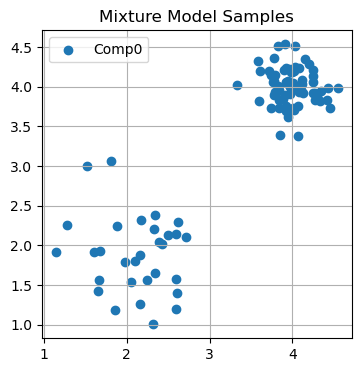

In [55]:
f,ax = plt.subplots(figsize=(4,4))

ax.grid()
ax.set_title("Mixture Model Samples")
plt.scatter(xs.T[0], xs.T[1])
ax.legend(["Comp0","Comp1"])
plt.show()

### Test 2

In [72]:
#Test2: init model sample from it, draw scatter plot, estimate parameters, check that the estimate is correct.
mus = [np.array([2,2]), np.array([4,4])]
sigmas = [0.2*np.eye(2), 0.05*np.eye(2)]
pis=[0.3,0.7]
mixMod = LogNMixtureModel(2,mus,sigmas,pis)

xs, ids = mixMod.sample(1000)

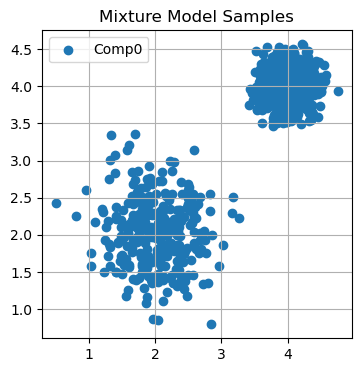

In [73]:
f,ax = plt.subplots(figsize=(4,4))

ax.grid()
ax.set_title("Mixture Model Samples")
plt.scatter(xs.T[0], xs.T[1])
ax.legend(["Comp0","Comp1"])
plt.show()

In [74]:
mus = [np.zeros([2]), np.zeros([2])]
sigmas = [np.eye(2), np.eye(2)]
pis=[0.9,0.1]
mixMod1 = LogNMixtureModel(2,mus,sigmas,pis)

mixMod1.fit(xs,500)
print(mixMod1)

EM Steps: 100%|███████████████████████████████| 500/500 [01:43<00:00,  4.85it/s]

LogN Mixture Model with 2 components
Component 1:
  Weight (pi): 0.6980
  Mean (mu): [3.99697799 4.0025892 ]
  Covariance (Sigma):
[[0.04693906 0.00435345]
 [0.00435345 0.04532902]]
Component 2:
  Weight (pi): 0.3020
  Mean (mu): [2.01897396 2.02939768]
  Covariance (Sigma):
[[ 0.18749843 -0.01206036]
 [-0.01206036  0.20663196]]



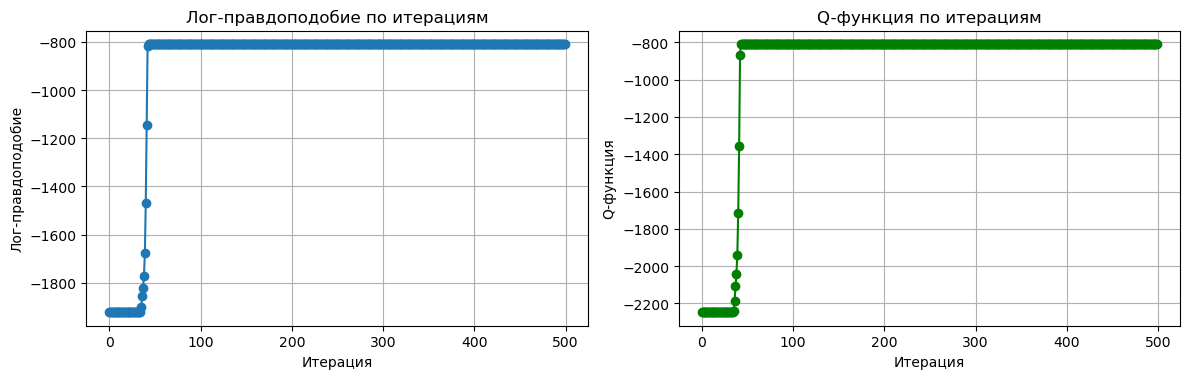

In [75]:
plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.grid()
plt.plot(mixMod1.log_likelihood_history, marker='o')
plt.title('Лог-правдоподобие по итерациям')
plt.xlabel('Итерация')
plt.ylabel('Лог-правдоподобие')

plt.subplot(2, 2, 2)
plt.grid()
plt.plot(mixMod1.Q_history, marker='o', color='green')
plt.title('Q-функция по итерациям')
plt.xlabel('Итерация')
plt.ylabel('Q-функция')



plt.tight_layout()
plt.show()

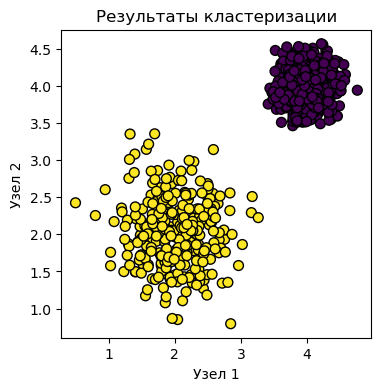

In [77]:
clusters = np.argmax(mixMod1.gammas, axis=1)

plt.figure(figsize=(4, 4))
plt.scatter(xs.T[0], xs.T[1], c=clusters, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('Результаты кластеризации')
plt.xlabel('Узел 1')
plt.ylabel('Узел 2')
plt.show()

Параметры должны быть примерно как настоящие, это очень простой случай для EM.

### Переходим к данным

Для оценки количества рабочих можно путём эксперимента подобрать количество кластеров. Попробуйте разное количество кластеров и подберите лучший. Ответьте на вопрос задачи и обоснуйте ваш выбор, используя написанный вами код.

In [68]:
with open("./maintenance.pkl","rb") as f:
    dd = pkl.load(f)
dd['times(min)'][:, 0] = np.log(dd['times(min)'][:, 0])
dd['times(min)'][:, 1] = np.log(dd['times(min)'][:, 1])


Оценка модели с 5 кластерами:


EM Steps: 100%|███████████████████████████████| 500/500 [02:06<00:00,  3.96it/s]


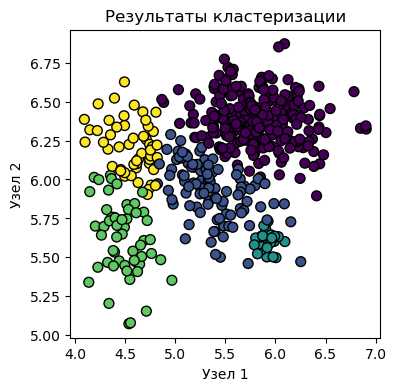


Оценка модели с 6 кластерами:


EM Steps: 100%|███████████████████████████████| 500/500 [02:38<00:00,  3.16it/s]


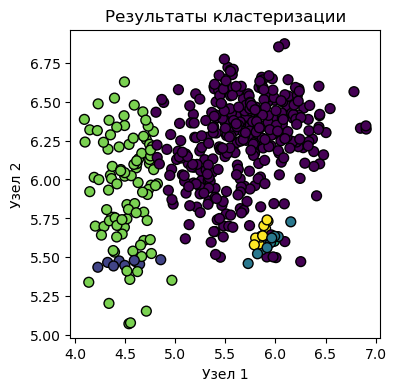


Оценка модели с 7 кластерами:


EM Steps: 100%|███████████████████████████████| 500/500 [03:06<00:00,  2.68it/s]


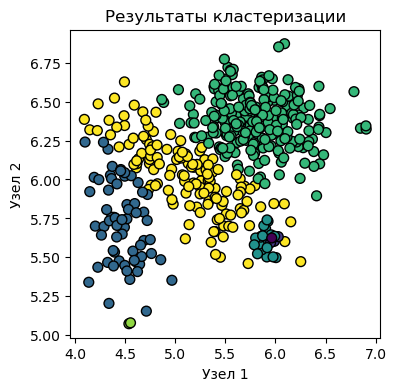


Оценка модели с 8 кластерами:


EM Steps: 100%|███████████████████████████████| 500/500 [03:32<00:00,  2.35it/s]


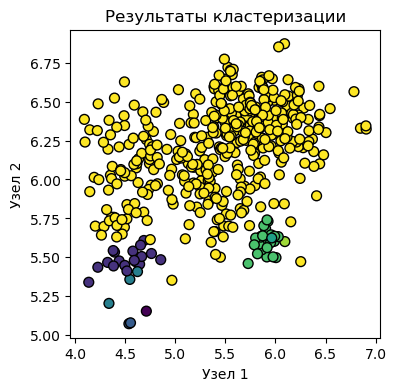

In [70]:
def evaluate_gmm(X, max_clusters):
    log_likelihoods = []
    silhouette_scores = []
    
    for k in range(5, max_clusters + 1):
        print(f'\nОценка модели с {k} кластерами:')
        model = LogNMixtureModel(K=k, 
                                 mus=np.random.rand(k, X.shape[1]), 
                                 sigmas=[np.cov(X, rowvar=False) for _ in range(k)], 
                                 pis=[1/k]*k)
        
        model.fit(data=X, nSteps=500)
        clusters = np.argmax(model.gammas, axis=1)

        plt.figure(figsize=(4, 4))
        plt.scatter(X.T[0], X.T[1], c=clusters, cmap='viridis', marker='o', edgecolor='k', s=50)
        plt.title('Результаты кластеризации')
        plt.xlabel('Узел 1')
        plt.ylabel('Узел 2')
        plt.show()

evaluate_gmm(dd['times(min)'], 8)

**При k = 5 - лучший кластер**

## Задача 2. Тотальный контроль (5 баллов)

В чат по теории вероятности сообщения приходят круглосуточно и особенно часто -- в кризисное время, когда у всех проходят коллоквиумы и разные другие контрольные мероприятия. Если выгрузить сырой лог из чата, то можно посчитать длину сообщения в символах $X$ и момент времени $T$, когда сообщение пришло в чат. Предполагается, что $X$ и $T$ независимы, а также промежутки времени $\Delta T_i = T_{i+1} - T_i$ являются независимыми в совокупности.

Исследуя интернет, вы наткнулись на подходящее [экспоненциальное распределение](https://en.wikipedia.org/wiki/Exponential_distribution), которое используется в survival analysis, исследовании времён до происхождения следующего события, которое можно использовать для моделирования времени, и на уже известное [логнормальное распределение](https://en.wikipedia.org/wiki/Log-normal_distribution) для моделирования длины сообщений (несмотря на то, что длины целые, мы попробуем).

На основе наблюдений предложите вероятностную модель на основе смесей распределений, которая помогла бы вам научиться определять, является ли конкретный момент времени $t$, когда было прислано сообщение длины $x$, кризисным.

Как и раньше, действуем по инструкции.

### Посмотрим на датасет

Откройте приложенный датасет и нарисуйте гистограммы для $X_i$ и $\Delta T_i$ -- длин сообщений и времени, прошедшего с предыдущего сообщения.

In [82]:
with open("./terver.pkl","rb") as f:
    dd = pkl.load(f)

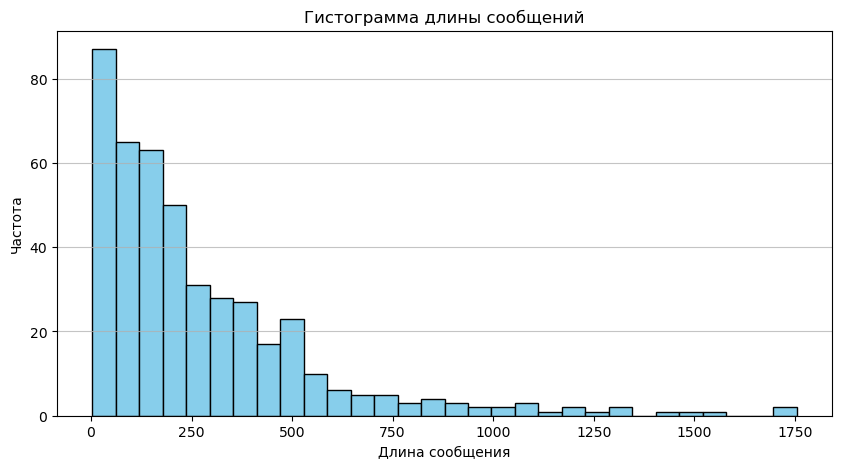

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


plt.figure(figsize=(10, 5))
plt.hist(dd['msgLen'], bins=30, color='skyblue', edgecolor='black')
plt.title('Гистограмма длины сообщений')
plt.xlabel('Длина сообщения')
plt.ylabel('Частота')
plt.grid(axis='y', alpha=0.75)
plt.show()

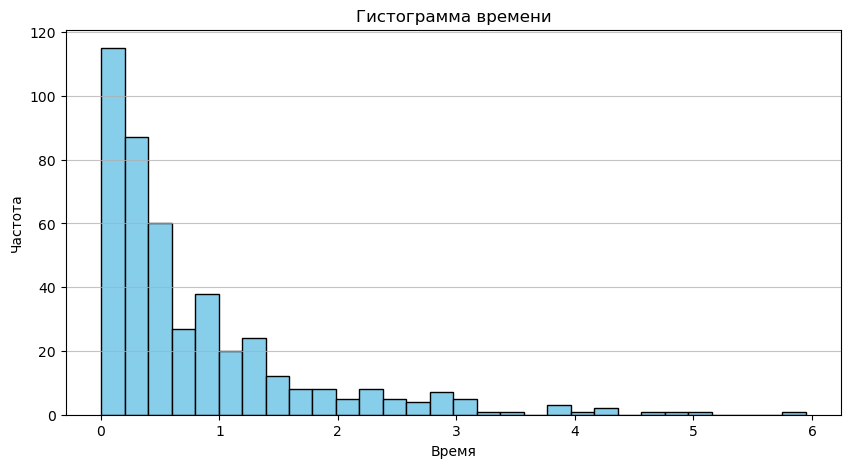

In [85]:
plt.figure(figsize=(10, 5))
plt.hist(dd['delta-times(min)'], bins=30, color='skyblue', edgecolor='black')
plt.title('Гистограмма времени')
plt.xlabel('Время')
plt.ylabel('Частота')
plt.grid(axis='y', alpha=0.75)
plt.show()

### Модель

Опишите модель смеси, которая вам пригодится для решения задачи. 

* Что по смыслу задачи является скрытыми переменными $Y_i$ (номерами компонент)?
* Какое вы можете предложить распределение для пары $(X^i, \Delta T_{i-1})$? Будьте здесь внимательны!
* Какие параметры $\theta$ есть в вероятностной модели?

* Скрытая переменная - состояние(кризисный или нормальный)
* Логнормальное распределение для длины сообщения, и экспоненциальное распределение для промежутки времени
* Параметры: $\mu_k$, $\sigma^2_k$, $\lambda_k$

### Матчасть

Построим математическую основу решения задачи. Выведите и запишите формулы для ЕМ-алгоритма: Е-шаг (вычисление необходимых весов наблюдений) и М-шаг (обновление параметров).

### E-шаг

$$
\gamma_{Y_i}(k) = P(Y_i = k | X^i, \Delta T_{i}) 
= \frac{P((X^i, \Delta T_{i}), Y_i = k)}{P(X^i, \Delta T_{i})}
= \frac{P((X^i, \Delta T_{i})| Y_i = k) \cdot P(Y_i = k)}{P(X^i, \Delta T_{i})}
= \frac{P(X^i| Y_i = k) \cdot P(\Delta T_{i}| Y_i = k) \cdot P(Y_i = k)}{P(X^i, \Delta T_{i})}
$$


- $
P(X_i| Y_i = k) = \frac{1}{x_i \sigma_k \sqrt{2\pi}} \exp\left( -\frac{(\ln x_i - \mu_k)^2}{2\sigma_k^2} \right)
$

- $
P(\Delta T_i| Y_i = k) = \lambda_k \exp(-\lambda_k \Delta T_i)
$

- $P(Y_i = k) = \pi_k$
- $P(X^i, \Delta T_{i})= \sum_{j=1}^{K} P((X^i, \Delta T_{i})| Y_i = j) \pi_j
=\sum_{j=1}^{K} P(X^i| Y_i = j) \cdot P(\Delta T_{i}| Y_i = j) \cdot \pi_j
$


Тогда:

$$
\gamma_{Y_i}(k) = \frac{P(X^i| Y_i = k) \cdot P(\Delta T_{i}| Y_i = k) \cdot \pi_k}{P(X^i| Y_i = 1) \cdot P(\Delta T_{i}| Y_i = 1) \cdot \pi_1 + P(X^i| Y_i = 0) \cdot P(\Delta T_{i}| Y_i = 0) \cdot \pi_0}
$$

### M-шаг

$$Q(\theta_t, \theta) = \sum \limits_{i=1}^n  \sum \limits_{k=1}^K \gamma_{Y_i}(k) \left( \ln \pi_k + \ln p_{\theta}(X^i, \Delta T_{i} \vert Y_i=k)\right)
$$

$
L =\sum \limits_{i=1}^n  \sum \limits_{k=1}^K \gamma_{Y_i}(k) \left( \ln \pi_k + \ln p_{\theta}(\Delta T_{i} \vert Y_i=k) + \ln p_{\theta}(X^i \vert Y_i=k)\right) + \lambda_{lag}(\sum \limits_{k=1}^K \pi_k - 1)
$

- Максимизируем по $\pi_k$ (аналогично 1 номеру)


$$
\hat{\pi}_k = \frac{1}{n} \sum_{i=1}^{n}{\gamma_{Y_i}(k)}
$$

- Максимизируем по $\mu_k$

$$
\frac{\partial L}{\partial \mu_k} =
\frac{\partial}{\partial \mu_k} \sum \limits_{i=1}^n  \sum \limits_{k=1}^K \gamma_{Y_i}(k) \left( \ln \pi_k + \ln p_{\theta}(\Delta T_{i} \vert Y_i=k) + \ln p_{\theta}(X^i \vert Y_i=k)\right)
= \sum \limits_{i=1}^n  \sum \limits_{k=1}^K \gamma_{Y_i}(k) \frac{\partial}{\partial \mu_k}\ln p_{\theta}(X^i \vert Y_i=k)
$$

$$
= \sum \limits_{i=1}^n \gamma_{Y_i}(k) \frac{\partial}{\partial \mu_k} \left( -\frac{(\ln x_i - \mu_k)^2}{2\sigma_k^2} \right) = \sum \limits_{i=1}^n \gamma_{Y_i}(k) \frac{(\ln x_i - \mu_k)}{\sigma_k^2} = 0
$$

$$
\Longrightarrow 
\hat{\mu}_k = \frac{\sum \limits_{i=1}^n \gamma_{Y_i}(k) \cdot \ln x_i}{\sum \limits_{i=1}^n \gamma_{Y_i}(k)}
$$

- Максимизируем по $\sigma^2_k$

$$
\frac{\partial L}{\partial \sigma_k} =
\frac{\partial}{\partial \sigma_k} \sum \limits_{i=1}^n  \sum \limits_{k=1}^K \gamma_{Y_i}(k) \left( \ln \pi_k + \ln p_{\theta}(\Delta T_{i} \vert Y_i=k) + \ln p_{\theta}(X^i \vert Y_i=k)\right)
= \sum \limits_{i=1}^n  \sum \limits_{k=1}^K \gamma_{Y_i}(k) \frac{\partial}{\partial \sigma_k}\ln p_{\theta}( X^i\vert Y_i=k)
$$

$$
= \sum \limits_{i=1}^n  \gamma_{Y_i}(k) \frac{\partial}{\partial \sigma_k}\left( -\ln(x_i \sigma_k \sqrt{2\pi}) - \frac{(\ln x_i - \mu_k)^2}{2\sigma_k^2} \right)
= \sum \limits_{i=1}^n  \gamma_{Y_i}(k) \left(-\frac{1}{\sigma_k} + \frac{(\ln x_i - \mu_k)^2}{\sigma_k^3}\right) = 0
$$
$$
\Longrightarrow \sum \limits_{i=1}^n \gamma_{Y_i}(k) \left(-1 + \frac{(\ln x_i - \mu_k)^2}{\sigma_k^2}\right) = 0
$$

$$
\hat{\sigma}_k^2 = \frac{\sum \limits_{i=1}^n \gamma_{Y_i}(k) \cdot (\ln x_i - \mu_k)^2}{\sum \limits_{i=1}^n \gamma_{Y_i}(k)}
$$

- Максимизируем по $\lambda_k$

$$
\frac{\partial L}{\partial \lambda_k} =
\frac{\partial}{\partial \lambda_k} \sum \limits_{i=1}^n  \sum \limits_{k=1}^K \gamma_{Y_i}(k) \left( \ln \pi_k + \ln p_{\theta}(\Delta T_{i} \vert Y_i=k) + \ln p_{\theta}(X^i \vert Y_i=k)\right)
= \sum \limits_{i=1}^n  \sum \limits_{k=1}^K \gamma_{Y_i}(k) \frac{\partial}{\partial \lambda_k}\ln p_{\theta}( \Delta T_i\vert Y_i=k)
$$

$$
= \sum \limits_{i=1}^n  \gamma_{Y_i}(k) \frac{\partial}{\partial \lambda_k}\left( \ln \lambda_k - \lambda_k \Delta T_i \right)
= \sum \limits_{i=1}^n \gamma_{Y_i}(k) \left(\frac{1}{\lambda_k} - \Delta T_i\right) = 0
$$

$$
\Longrightarrow \hat{\lambda}_k = \frac{\sum \limits_{i=1}^n \gamma_{Y_i}(k)}{\sum \limits_{i=1}^n \gamma_{Y_i}(k) \cdot \Delta T_i}
$$

### Имплементация модели

Будем использовать уже знакомый пайплайн для смеси распределений, который вы видели в семинарах, как основу. Вам предлагается заполнить детали и дописать вычисление Q-функции и лог-правдоподобия для логирования. Предлагаемые тесты смотрите ниже.

* Напишите код модели: начните с заполнения ``init`` и ``sample``, протестируйте, что всё семплится, как вы ожидаете (см. первый тест ниже).
* Добавьте ``fit`` и протестируйте его, он должен корректно оценивать параметры по выборке (см. второй тест ниже)
* Нарисуйте в каждом тесте график зависимости логправдоподобия (по наблюдаемым переменным) и Q-функции от номера итерации, чтобы убедиться, что алгоритм к чему-то сходится.

In [198]:
class CustomMixtureModel:
    '''
    Implements Weibull Mixture Model in R^d
    '''

    def __init__(self,K,lambdas, pis, mus, sigmas):
        """
        Args:
            K (int, optional): number of components.
            mus (list, optional): K entries of (d,), expected values.
            sigmas (list, optional): K entries of (d,d,), covariances.
            pis (list, optional): K floats, weights, positive and sump up to 1.
        """
        self.K = 2
        self.mus = np.array(mus)
        self.sigmas = np.array(sigmas)
        self.pis = np.array(pis)
        self.lambdas = np.array(lambdas)
        self.gammas = None
        self.log_likelihood_history = []
        self.Q_history = []

    def __str__(self):
        """Prints the parameters

        Returns:
            out (str): text print
        """ 
        return f"CustomMixture:\n pis={self.pis},\n mus={self.mus},\n sigmas={self.sigmas},\n lambdas={self.lambdas}"

    def sample(self, N=10):
        """Samples N samples from the model

        Args:
            N (int, optional): number of samples. Defaults to 10.

        Returns:
           result(float[]) : N d-dimensional samples (N,d)
           ids(int[]) : mixture ids (N,)
        """        
        ids = np.random.choice(self.K, size=N, p=self.pis)
        X = np.random.lognormal(mean=self.mus[ids], sigma=self.sigmas[ids])
        Delta_T = np.random.exponential(scale=1.0 / self.lambdas[ids])
        samples = np.vstack((X, Delta_T)).T
        return samples, ids

    def EStep(self, data):
        """Performs E-Step (computation of theta0 weights)

        Args:
            data (float[]): Training data (N,d)
        """
        X = data[:, 0]
        Delta_T = data[:, 1]
        N = X.shape[0]
        gamma = np.zeros((N, self.K))
        
        for k in range(self.K):
            pi_k = self.pis[k]
            lognormal_pdf = (1 / (X * self.sigmas[k] * np.sqrt(2 * np.pi))) * \
                            np.exp(- (np.log(X) - self.mus[k])**2 / (2 * self.sigmas[k]**2))
            exponential_pdf = self.lambdas[k] * np.exp(-self.lambdas[k] * Delta_T)
            gamma[:, k] = pi_k * lognormal_pdf * exponential_pdf
        
        gamma_sum = np.sum(gamma, axis=1, keepdims=True)
        gamma_sum[gamma_sum == 0] = 1e-16
        self.gammas = gamma / gamma_sum
    
    def MStep(self, data):
        """Performs M-Step (weight update)

        Args:
            data (float[]): Training data (N,d)
        """        
        N, d = data.shape
        X = data[:, 0]
        Delta_T = data[:, 1]
        gamma = self.gammas
        N_k = np.sum(gamma, axis=0)
        self.pis = N_k / N
        self.mus = np.zeros(self.K)
        self.sigmas = np.zeros(self.K)
        for k in range(self.K):
            weighted_log_X = gamma[:, k] * np.log(X)
            self.mus[k] = np.sum(weighted_log_X) / N_k[k]
            weighted_log_X_squared = gamma[:, k] * (np.log(X) - self.mus[k])**2
            self.sigmas[k] = np.sqrt(np.sum(weighted_log_X_squared) / N_k[k])
        
        for k in range(self.K):
            self.lambdas[k] = N_k[k] / np.sum(gamma[:, k] * Delta_T)
        
        
    def fit(self, data, nSteps):
        """Fits the model

        Args:
            data (float[]): (batch, d), given data
            nSteps (int): number of steps for EM
        """        
        log_likelihood_old = None
        
        for step in tqdm.tqdm(range(nSteps), desc="EM Steps"):
            self.EStep(data)
            self.MStep(data)
            
            log_likelihood = self._loglike(data)
            self.log_likelihood_history.append(log_likelihood)
            Q = self._Qfun(data)
            self.Q_history.append(Q)
            log_likelihood_old = log_likelihood
            
    def _Qfun(self,data):
        """Computes Q-function

        Args:
            data (float[]): given data (N,2)
        Returns:
            qfun (float): Qfunction value
        """
        X = data[:, 0]
        Delta_T = data[:, 1]
        Q = 0.0
        for k in range(self.K):
            pi_k = self.pis[k]
            gamma_k = self.gammas[:, k]
            lognormal_pdf = (1 / (X * self.sigmas[k] * np.sqrt(2 * np.pi))) * \
                            np.exp(- (np.log(X) - self.mus[k])**2 / (2 * self.sigmas[k]**2))
            exponential_pdf = self.lambdas[k] * np.exp(-self.lambdas[k] * Delta_T)
            Q += np.sum(gamma_k * (np.log(pi_k + 1e-10) + 
                                   np.log(lognormal_pdf + 1e-10) + 
                                   np.log(exponential_pdf + 1e-10)))
        return Q
                
    def _loglike(self,data):
        """Computes observable log-likelihood

        Args:
            data (float[]): given data (N,2)
        Returns:
            loglike (float): log-likelihood value
        """
        X = data[:, 0]
        Delta_T = data[:, 1]
        log_likelihood = 0.0
        for k in range(self.K):
            pi_k = self.pis[k]
            lognormal_pdf = (1 / (X * self.sigmas[k] * np.sqrt(2 * np.pi))) * \
                            np.exp(- (np.log(X) - self.mus[k])**2 / (2 * self.sigmas[k]**2))
            exponential_pdf = self.lambdas[k] * np.exp(-self.lambdas[k] * Delta_T)
            log_likelihood += pi_k * lognormal_pdf * exponential_pdf
        return np.sum(np.log(log_likelihood + 1e-10))

In [199]:
#Test1: init model and sample from it, draw scatter plot

pis = [0.4, 0.6]
mus = [0.2, 1.0]
sigmas = [0.5, 0.6]
lambdas = [1.2, 0.9]
mixMod = CustomMixtureModel(2, lambdas, pis, mus, sigmas,)

xs, ids = mixMod.sample(100)

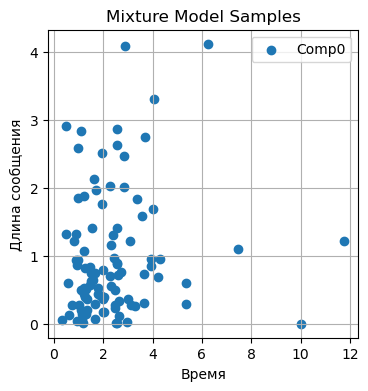

In [200]:
f,ax = plt.subplots(figsize=(4,4))

ax.grid()
ax.set_title("Mixture Model Samples")
plt.scatter(xs.T[0], xs.T[1])
ax.legend(["Comp0","Comp1"])
plt.ylabel("Длина сообщения")
plt.xlabel("Время")
plt.show()

In [201]:
#Test2: init model sample from it, draw scatter plot, estimate parameters, check that the estimate is correct.
pis = [0.4, 0.6]
mus = [0.2, 1.0]
sigmas = [0.5, 0.6]
lambdas = [1.2, 0.9]
mixMod = CustomMixtureModel(2, lambdas, pis, mus, sigmas,)

xs, ids = mixMod.sample(500)

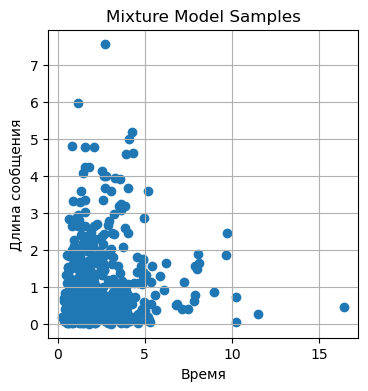

In [202]:
f,ax = plt.subplots(figsize=(4,4))

ax.grid()
ax.set_title("Mixture Model Samples")
plt.scatter(xs.T[0], xs.T[1])
plt.ylabel("Длина сообщения")
plt.xlabel("Время")
plt.show()

In [203]:
mixMod.fit(xs, 500)
print(mixMod)

EM Steps: 100%|█████████████████████████████| 500/500 [00:00<00:00, 5548.04it/s]

CustomMixture:
 pis=[0.35542669 0.64457331],
 mus=[0.21184779 0.90213223],
 sigmas=[0.53452655 0.59254274],
 lambdas=[1.24542742 0.8398032 ]


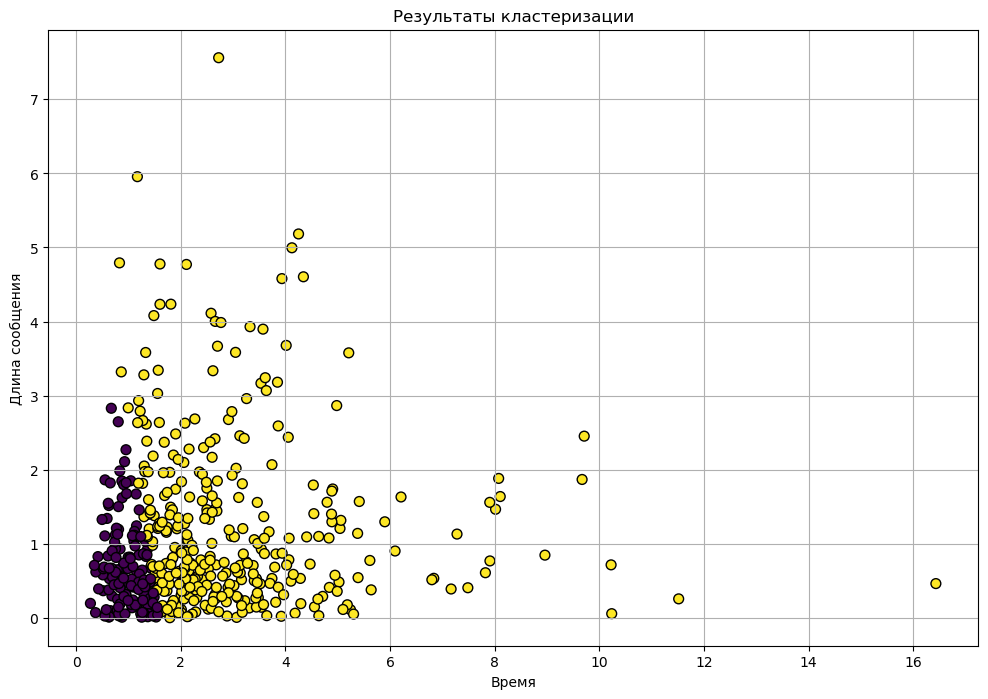

In [204]:
clusters = np.argmax(mixMod.gammas, axis=1)

plt.figure(figsize=(12, 8))
plt.grid()
plt.scatter(xs.T[0], xs.T[1], c=clusters, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('Результаты кластеризации')
plt.ylabel("Длина сообщения")
plt.xlabel("Время")
plt.show()

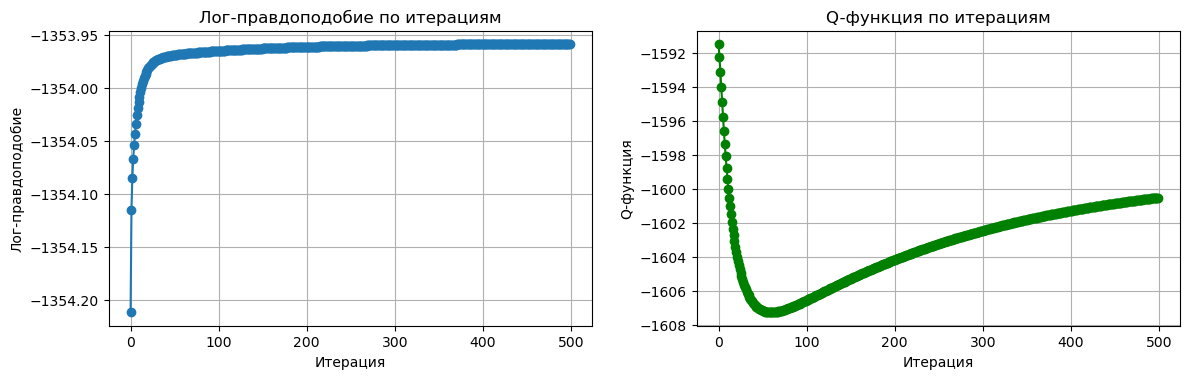

In [205]:
plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.grid()
plt.plot(mixMod.log_likelihood_history, marker='o')
plt.title('Лог-правдоподобие по итерациям')
plt.xlabel('Итерация')
plt.ylabel('Лог-правдоподобие')

plt.subplot(2, 2, 2)
plt.grid()
plt.plot(mixMod.Q_history, marker='o', color='green')
plt.title('Q-функция по итерациям')
plt.xlabel('Итерация')
plt.ylabel('Q-функция')

plt.tight_layout()
plt.show()

In [206]:
pis = [0.4, 0.6]
mus = [0.2, 1.0]
sigmas = [0.5, 0.6]
lambdas = [1.2, 0.9]
mixMod_res = CustomMixtureModel(2, lambdas, pis, mus, sigmas)


data = np.column_stack((dd['msgLen'], dd['delta-times(min)']))
mixMod_res.fit(data, 1000)

EM Steps: 100%|███████████████████████████| 1000/1000 [00:00<00:00, 7275.22it/s]


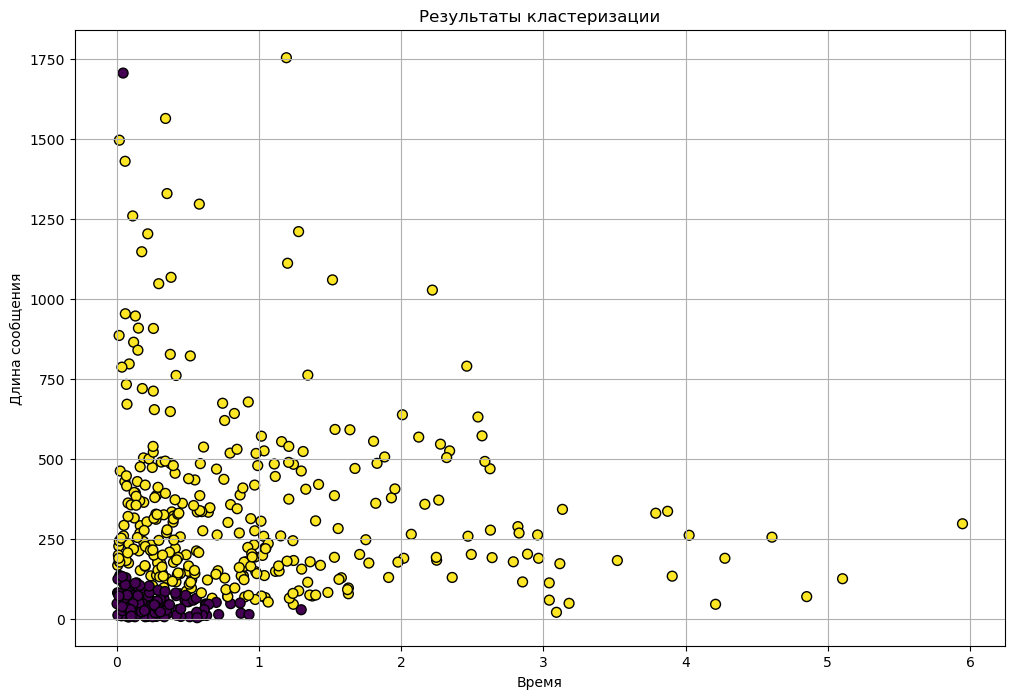

In [212]:
clusters = np.argmax(mixMod_res.gammas, axis=1)

plt.figure(figsize=(12, 8))
plt.grid()
plt.scatter(dd['delta-times(min)'], dd['msgLen'], c=clusters, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('Результаты кластеризации')
plt.ylabel("Длина сообщения")
plt.xlabel("Время")
plt.show()

### Ответы

Какие сообщения были написаны в кризисное время, а какие в нормальное? Ответ: Темные точки на графике

Какая доля сообщений была написана в кризисное время?

Обоснуйте свои ответы, используя ваш код.

In [208]:
cluster_means = mixMod_res.mus
crisis_cluster = np.argmin(cluster_means)
clusters = np.argmax(mixMod_res.gammas, axis=1)
total_messages = len(clusters)
crisis_messages = np.sum(clusters == crisis_cluster)

print(f"crisis_messages: {crisis_messages}")
print(f"total_messages: {total_messages}")
print(f"Доля: {crisis_messages / total_messages * 100}%")

crisis_messages: 119
total_messages: 445
Доля: 26.741573033707866%
